# 계절 별 PM10에 대한 차이가 존재하는 가

In [9]:
import numpy as np
import pandas as pd
# 출처 : https://www.airkorea.or.kr/web/pastSearch?pMENU_NO=123
# 다 다운받아서 추합함.

df18 = pd.read_csv("./data/finedust/data_agg(2018).csv")
df18.drop(['Unnamed: 0'], axis = 1, inplace = True)

df19 = pd.read_csv("./data/finedust/data_agg(2019).csv")
df19.drop(['Unnamed: 0'], axis = 1, inplace = True)

df20 = pd.read_csv("./data/finedust/data_agg(2020).csv")
df20.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [10]:
# df datetime type으로 바꾸기

df18["날짜"] = pd.to_datetime(df18["날짜"].apply(lambda x :"2018-"+x if x[-2:] != "24" else "2018-"+x[:-2] + "0"), format='%Y-%m-%d-%H')
df19["날짜"] = pd.to_datetime(df19["날짜"].apply(lambda x :"2019-"+x if x[-2:] != "24" else "2019-"+x[:-2] + "0"), format='%Y-%m-%d-%H')
df20["날짜"] = pd.to_datetime(df20["날짜"].apply(lambda x :"2020-"+x if x[-2:] != "24" else "2020-"+x[:-2] + "0"), format='%Y-%m-%d-%H')

In [11]:
df = pd.concat([df18, df19, df20])
df.index = range(len(df))
df.columns = ["date", "PM10", "PM2.5", "O3", "NO2", "CO", "SO2"]

In [12]:
import warnings
warnings.filterwarnings("ignore")

<AxesSubplot:>

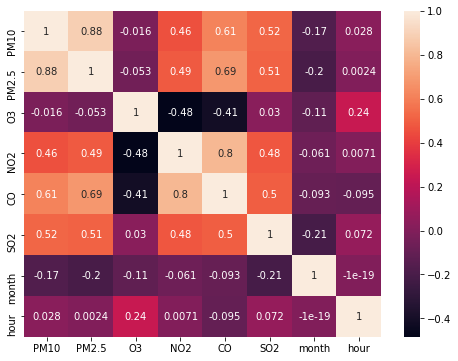

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(df["PM10"])
ax.plot(df["PM2.5"])

sns.heatmap(df.corr(), annot=True)

- 위 correlation coef를 확인해 본 결과 (PM10, PM2.5), (CO2, NO2)에서 높은 양의 상관관계를 확인할 수 있음.
- 월, 시간대, 계절 column 추가
- 계절별, 월별, 시간대별 PM10 추이에 대한 유의성 검정

In [15]:
def season(date):
    if date.month in [3,4,5]:
        return "spring"
    elif date.month in [6,7,8]:
        return "summer"
    elif date.month in [9,10,11]:
        return "fall"
    else:
        return "winter"

df["season"] = df["date"].apply(lambda x: season(x))
df["month"] = df["date"].apply(lambda x : x.month)
df["hour"] = df["date"].apply(lambda x : x.hour)

### 모형에 대한 해석

- 여름, 가을에 비해 봄, 겨울에서의 미세먼지 양이 더 많다고 생각된다.
- 계절에 따라 유의미한 차이가 있는지 확인하기 위해 시각화(Box plot) 및 ANOVA test

In [17]:
import statsmodels.api as sm

model = sm.OLS.from_formula("PM10 ~ C(season) + 0", data=df)
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     1079.
Date:                Sat, 22 May 2021   Prob (F-statistic):               0.00
Time:                        10:48:48   Log-Likelihood:            -1.1803e+05
No. Observations:               25919   AIC:                         2.361e+05
Df Residuals:                   25915   BIC:                         2.361e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
C(season)[fall]      31.9989      0.28

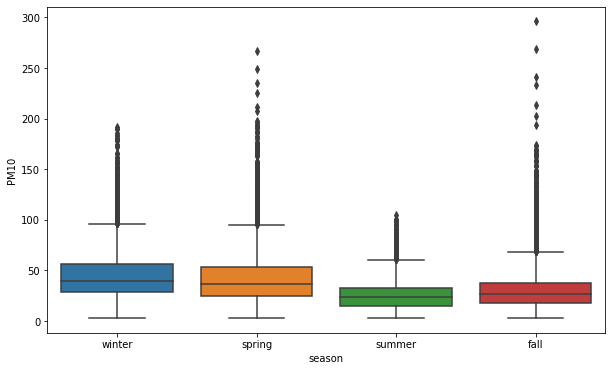

In [18]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.boxplot(x="season", y="PM10", data=df)

- 집단간 평균에 대한 ANOVA test
- 집단 간 동분산성 test 결과 두 test 모두에서 기각되었음.
- 동분산성이 무너진 상황에서의 ANOVA를 위한 pingouin library 설치 및 welch ANOVA test

In [19]:
from scipy import stats

x1 = df[df["season"] == "spring"]["PM10"]
x2 = df[df["season"] == "summer"]["PM10"]
x3 = df[df["season"] == "fall"]["PM10"]
x4 = df[df["season"] == "winter"]["PM10"]

# p-value가 둘다 매우 낮으므로 기각.
print(stats.bartlett(x1,x2,x3, x4))
print(stats.fligner(x1, x2, x3, x4))

BartlettResult(statistic=2502.5649890699547, pvalue=0.0)
FlignerResult(statistic=21646.288671474405, pvalue=0.0)


$H_{0} : \mu_1 = \mu_2 = \mu_3 = \mu_4$ $\;$ vs $\;$  $not\;H_{0}$

In [20]:
from pingouin import welch_anova

aov = welch_anova(dv='PM10', between='season', data=df) 
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,season,3,13891.676374,1398.860038,0.0,0.111011


- 결과해석 :
<br>
welch ANOVA 테스트 결과 집단 간 평균이 유의미하게 차이가 난다는 결론을 내릴 수 있다.

# PCA를 통한 차원축소 및 데이터 해석
- 2개의 새로운 축만으로 데이터의 전체 variability 중 95%정도를 설명

In [125]:
air = pd.read_csv("./data/AIR_POLLUTION.csv")
X = air.drop("MeasDate", axis=1)
X.dropna(inplace = True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = X - np.mean(X, axis=0)

pca = PCA()
pca_transformed = pca.fit_transform(X)
PC1_axis = pca_transformed[:, 0]
PC2_axis = pca_transformed[:, 1]
X["PC1"] = PC1_axis
X["PC2"] = PC2_axis

air = pd.read_csv("./data/AIR_POLLUTION.csv")
X = air.drop("MeasDate", axis=1)
X.dropna(inplace = True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
c = X.columns
X_standard = pd.DataFrame(scaler.fit_transform(X), columns = c)

pca2 = PCA()
pca2_transformed = pca2.fit_transform(X_standard)
PC1_axis2 = pca2_transformed[:, 0]
PC2_axis2 = pca2_transformed[:, 1]
X_standard["PC1"] = PC1_axis2
X_standard["PC2"] = PC2_axis2

### Mean Centering vs. Standardization

- Mean Centered data : In the case which there is reason to believe that the variances of
the variables do indicate the importance of a given variable

- Standardized data : In the case which a variable should not receive an artificially
higher weight than the others

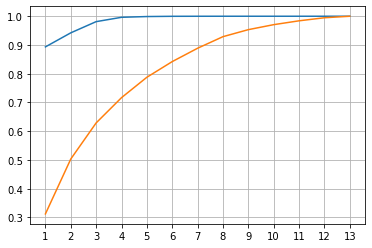

In [129]:
fig, ax = plt.subplots()

ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.plot(np.cumsum(pca2.explained_variance_ratio_))
ax.set_xticks(list(range(13)))
ax.set_xticklabels(list(range(1,14)))
ax.grid()

- Mean Centering의 경우 단 2개의 PC axis만으로 95%를 설명하는 반면, 표준화의 경우 급격한 elbow 포인트를 찾아볼 수 없다.
- 여기서, 전자를 사용할지 후자를 사용할지 고민해 봐야 하는데, 그 기준이 개별 variable의 variance를 중요하게 생각해야할까로부터 시작된다.
- 따라서 이를 해석해보면, mean centering의 경우 WIND_DIR이 다른 데이터들에 비해 표준편차가 매우 크고, 이 데이터를 우선적으로 고려하여 PC1 axis가 만들어졌다는 것을 알 수 있다.

In [137]:
np.sqrt(np.var(X))

PM10         16.066543
O3            0.011718
NO2           0.010771
CO            0.152574
SO2           0.000643
TEMP          9.044732
RAIN          1.027886
WIND          0.696473
WIND_DIR     71.337958
HUMIDITY     14.153473
ATM_PRESS     7.882217
SNOW          0.240666
CLOUD         3.000123
dtype: float64

- 해석하기를, WIND_DIR은 방향벡터 각도를 의미하는 것 같다. 이를 정량적으로 분석하기 어렵기 때문에 이 feature가 의미하는 것이 무엇인지 알고 싶었고,
- 이 feature의 의미를 표준화를 통해 상쇄시키고 싶지 않았다. 그래서 정규화보다는 mean centering 방법을 활용하였다.

### 두개의 축(PC1, PC2)을 활용하여 PM10 추이를 확인

- PC1에 따른 PM10의 추이는 명확하다고 보기 힘든 반면
- PC2값에 따른 PM10의 추이는 작을수록(클수록) PC10도 작다(크다)라고 해석할 수 있다.
- PM10의 경우 PC1에 비해 PC2가 훨씬 더 선형적인 관계를 잘 담고 있고, 이를 설명한다.

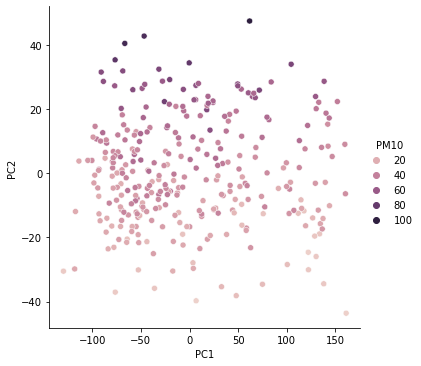

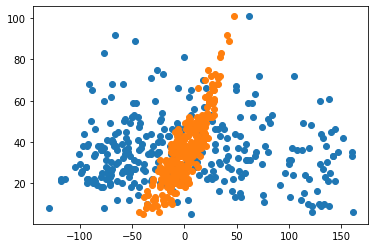

In [113]:
sns.relplot(x="PC1", y="PC2",hue="PM10", data=X)

fig, ax = plt.subplots()

ax.scatter(X["PC1"], X["PM10"])
ax.scatter(X["PC2"], X["PM10"])

- PM10을 PC2에 대해 선형회귀식을 만들어보면,
<br>
$PM10=\beta_0+\beta_1 PC2+\epsilon$

In [114]:
mod = sm.OLS.from_formula("PM10 ~ PC2", data=X)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     868.7
Date:                Sat, 22 May 2021   Prob (F-statistic):           8.86e-92
Time:                        12:00:40   Log-Likelihood:                -1096.8
No. Observations:                 311   AIC:                             2198.
Df Residuals:                     309   BIC:                             2205.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.4791      0.468     75.782      0.0

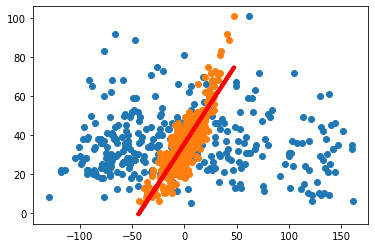

In [115]:
fig, ax = plt.subplots()

ax.scatter(X["PC1"], X["PM10"])
ax.scatter(X["PC2"], X["PM10"])
ax.plot(X["PC2"], 35.4791+ 0.8264*X["PC2"], c = "r", lw=4)

- 잔차간 독립성 및 정규성 시각화 결과를 통해
- 모형이 유의하다는 판단을 내림.

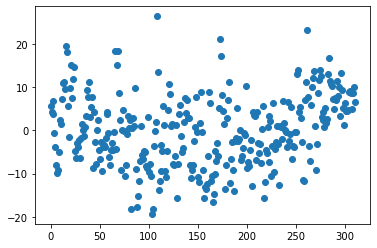

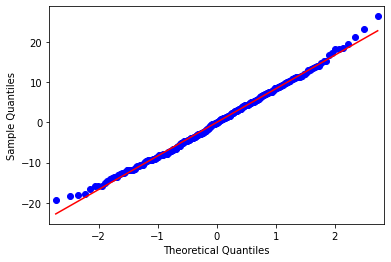

In [103]:
from statsmodels.api import qqplot

fig, ax = plt.subplots()

ax.scatter(range(len(res.resid)),res.resid)

qqplot(res.resid, line="r")
plt.show()

### 2번째 축 PC2에 대한 해석

우선적으로, PC2의 값에 따른 PM10의 회귀식은 다음과 같이 나타난다.
<br>
$PM10=35.4791+0.8264 PC2+\epsilon$

i번째 PC2값에 영향을 끼치는 weight의 해석
<br>
$PC2_i=w_1x_{i1}+w_2x_{i2}+...+w_px_{ip}$

In [143]:
for i, j in zip(X.columns, pca.components_[:,1]):
    print(i, round(j, 4))

PM10 -0.0001
O3 -0.0002
NO2 0.0001
CO 0.0008
SO2 0.0005
TEMP -0.0006
RAIN -0.0001
WIND -0.0045
WIND_DIR 0.0031
HUMIDITY -0.0139
ATM_PRESS 0.8695
SNOW -0.4938
CLOUD -0.0019


- 이러한 정보를 토대로 해석하면, PM10은 PC2 값이 올라감에 따라 올라가는 추세를 보이는데,
- PC2 값은 ATM_PRESS에 대해 양의 상관관계, SNOW에 대해 음의 상관관계를 보인다.

# 바람이 많이 불면 NO2가 exponential하게 decay된다.

$NO_2$ = $\beta e^{\gamma WIND}$+$\epsilon$

<br>
beta는 decaying parameter
위 식을 정리하면, 아래와 같은 WIND에 대한 선형식이 만들어지고 exponential decay parameter beta를 추정할 수 있게 된다.

<br>

$logNO_2$=$log\beta$+$\gamma WIND$+$log\epsilon$

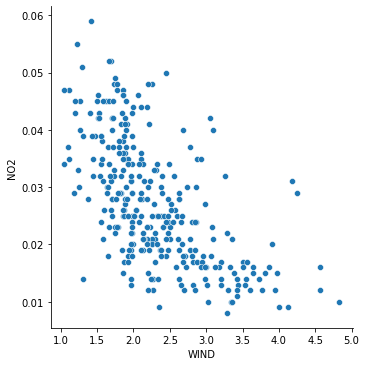

In [475]:
sns.relplot(X["WIND"], X['NO2'], ax= ax)

In [371]:
new_X = X[["WIND", "NO2"]]
new_X["logNO2"] = np.log(new_X["NO2"])
model = sm.OLS.from_formula("logNO2 ~ WIND", data=new_X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 logNO2   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     228.4
Date:                Fri, 21 May 2021   Prob (F-statistic):           5.09e-39
Time:                        23:59:34   Log-Likelihood:                -84.073
No. Observations:                 311   AIC:                             172.1
Df Residuals:                     309   BIC:                             179.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7873      0.062    -45.083      0.0

- 절편에 대한 유의성을 확보하였고, 위 식으로부터 $log\beta = -2.7873$, $\beta=e^{-2.7873}=0.0616$를 얻을 수 있다.
- 추가적으로 gamma는 -0.3914임.
- 그래서 결국 최종 식은 $NO_2$ = $0.0616 e^{-0.3914 WIND}$+$\epsilon$이 된다.
- 이 식을 위 그래프에 겹쳐 같이 그리면,

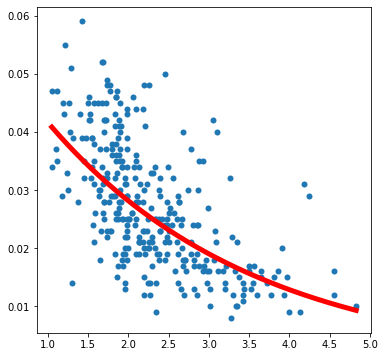

In [478]:
fig, ax = plt.subplots(figsize=(6,6))
l = np.linspace(X["WIND"].min(), X["WIND"].max(), 500)

ax.scatter(X["WIND"], X['NO2'], lw=0.01)
ax.plot(l, 0.0616*np.exp(-0.3914*l), c = "red", lw=5)

### CO와 NO2는 매우 밀접한 양의 상관관계를 가지고 있다.

In [474]:
import scipy

r, p = scipy.stats.pearsonr(CO_NO["CO"], CO_NO["NO2"])
print(r, p)

0.8110934191426942 6.009690031417371e-74


In [471]:
CO_NO = X[["CO", "NO2"]]

mod = sm.OLS.from_formula("NO2 ~ CO" , data = CO_NO)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     594.2
Date:                Sat, 22 May 2021   Prob (F-statistic):           6.01e-74
Time:                        01:15:10   Log-Likelihood:                 1134.6
No. Observations:                 311   AIC:                            -2265.
Df Residuals:                     309   BIC:                            -2258.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0022      0.001     -1.766      0.0

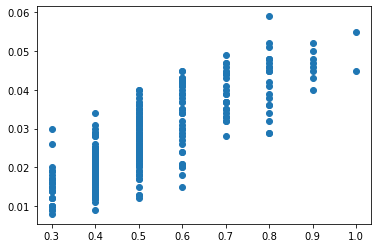

In [468]:
plt.scatter(X["CO"], X["NO2"])